# Initial attempt to learn from SF data

We use only part of the data (exp22-24) and a basic algorithm (Ridge regression)

In [4]:
import sys
import os

sys.path.insert(0, os.path.abspath('../..'))

from definitions import DB_PATH
from src.db_retrieval.db_queries import MyDatabaseConnection

In [8]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [9]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [10]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 53224


/var/folders/bw/f4bnnf4n0c94qdgp8y3gvxsc0000gn/T/ipykernel_50268/3129990183.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})


In [38]:
# select experiment numbers for further analysis
start_exp_nr = 22
end_exp_nr = 24  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  # kick out invalid experiments (SOP changed after exp3)
print(f'Number of reactions considered here: {len(df_full)}')

Number of reactions considered here: 5760


In [39]:
from rdkit import Chem
from rdkit.Chem.Descriptors import rdMolDescriptors

In [40]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

get_descriptors = rdMolDescriptors.Properties(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [41]:
df_full['descriptors'] = df_full["product_A_smiles"].apply(smi_to_descriptors)

/var/folders/bw/f4bnnf4n0c94qdgp8y3gvxsc0000gn/T/ipykernel_50268/1407491631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['descriptors'] = df_full["product_A_smiles"].apply(smi_to_descriptors)


In [42]:
df_full

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid,descriptors
id,,,,,,,,,,,,,,,,,,,,,
49042,22,4,A10,JG360,2022-07-13,I65,M20,T21,Ph021,Mon017,...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(c2ccno2...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(c3ccno3...,Fc1ccc(-c2nnc(-c3ccno3)s2)cc1F,c1cc(-c2nnc(-c3ccno3)s2)on1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(F)c...,CC(C)(C)OC(=O)CCC=Cc1nnc(-c2ccno2)s1,194976,WARNING: multiple peaks for product A (2),"[464.132982624, 464.4940000000001, 8.0, 1.0, 8..."
49043,22,4,A11,JG360,2022-07-13,I65,M20,T13,Ph021,Mon017,...,COc1ccc2c(c1)SC(C[C@H](CCC(=O)OC(C)(C)C)NC(=O)...,COc1ccc2c(c1)SC1(C(=O)[O-])C[C@H](CCC(=O)OC(C)...,COc1ccc2nc(-c3ccc(F)c(F)c3)sc2c1,COc1ccc(N)c(SSc2cc(OC)ccc2N)c1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(F)c...,COc1ccc2nc(C=CCCC(=O)OC(C)(C)C)sc2c1,194968,None,"[476.15813475199997, 476.54500000000013, 6.0, ..."
49044,22,4,A12,JG360,2022-07-13,I65,M20,T27,Ph021,Mon017,...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(c2ccc(O...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(c3ccc(O...,Oc1ccc(-c2nnc(-c3ccc(F)c(F)c3)s2)cc1,Oc1ccc(-c2nnc(-c3ccc(O)cc3)s2)cc1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(F)c...,CC(C)(C)OC(=O)CCC=Cc1nnc(-c2ccc(O)cc2)s1,194982,WARNING: multiple peaks for product A (2),"[489.1533837200001, 489.5440000000001, 7.0, 2...."
49045,22,4,A13,JG360,2022-07-13,I65,M34,T28,Ph021,Mon076,...,CC(C)(C)OC(=O)N1CCC([C@H](CC2(C(=O)O)NN=C(c3cc...,CC(C)(C)OC(=O)N1CCC([C@@H]2CC3(C(=O)[O-])SC(c4...,Fc1ccc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)cc1F,FC(F)(F)c1ccc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)cc1,CC(C)(C)OC(=O)N1CCC([C@H](CC(=O)C(=O)O)NC(=O)c...,CC(C)(C)OC(=O)N1CCC([C@H](CC(=O)O)NC(=O)c2ccc(...,CC(C)(C)OC(=O)N1CCC(C=Cc2nnc(-c3ccc(C(F)(F)F)c...,195557,WARNING: multiple peaks for product A (2),"[596.188052888, 596.622, 7.0, 1.0, 6.0, 1.0, 6..."
49046,22,4,A14,JG360,2022-07-13,I65,M34,T32,Ph021,Mon076,...,CC(C)(C)OC(=O)N1CCC([C@H](CC2(C(=O)O)NN=C(c3cc...,CC(C)(C)OC(=O)N1CCC([C@@H]2CC3(C(=O)[O-])SC(c4...,Fc1ccc(-c2nnc(-c3ccccc3Cl)s2)cc1F,Clc1ccccc1-c1nnc(-c2ccccc2Cl)s1,CC(C)(C)OC(=O)N1CCC([C@H](CC(=O)C(=O)O)NC(=O)c...,CC(C)(C)OC(=O)N1CCC([C@H](CC(=O)O)NC(=O)c2ccc(...,CC(C)(C)OC(=O)N1CCC(C=Cc2nnc(-c3ccccc3Cl)s2)CC1,195561,WARNING: multiple peaks for product A (2),"[562.161695908, 563.0699999999999, 7.0, 1.0, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54797,22,3,P5,JG359,2022-07-13,I44,M51,T31,BiPh007,Mon097,...,COc1ccccc1C1=NNC(C[C@H](NC(=O)c2ccc(C(=O)O)cc2...,COc1ccccc1C1=N[N+]2=C(c3ccc(C(=O)O)cc3)N[C@H](...,COc1ccccc1-c1nnc(-c2ccc(C(=O)O)cc2)s1,COc1ccccc1-c1nnc(-c2ccccc2OC)s1,O=C(O)C(=O)C[C@H](NC(=O)c1ccc(C(=O)O)cc1)c1cnco1,O=C(O)C[C@H](NC(=O)c1ccc(C(=O)O)cc1)c1cnco1,COc1ccccc1-c1nnc(C=Cc2cnco2)s1,132543,WARNING: multiple peaks for product A (2),"[450.09979067599994, 450.4760000000001, 9.0, 2..."
54798,22,3,P6,JG359,2022-07-13,I44,M51,T40,BiPh007,Mon097,...,O=C(O)c1ccc(C(=O)N[C@@H](CC2(C(=O)O)NN=C(c3ccc...,O=C(O)c1ccc(C2=[N+]3N=C(c4ccc5[nH]nnc5c4)SC3(C...,O=C(O)c1ccc(-c2nnc(-c3ccc4[nH]nnc4c3)s2)cc1,c1cc2[nH]nnc2cc1-c1nnc(-c2ccc3[nH]nnc3c2)s1,O=C(O)C(=O)C[C@H](NC(=O)c1ccc(C(=O)O)cc1)c1cnco1,O=C(O)C[C@H](NC(=O)c1ccc(C(=O)O)cc1)c1cnco1,C(=Cc1nnc(-c2ccc3[nH]nnc3c2)s1)c1cnco1,132552,ERROR: too many peaks for product A (6),"[461.0906229600001, 461.4630000000001, 11.0, 3..."
54799,22,3,P7,JG359,2022-07-13,I44,M51,T20,BiPh007,Mon097,...,O=C(O)c1ccc(C(=O)N[C@@H](CC2(C(=O)O)NN=C(c3ccc...,O=C(O)c1ccc(C2=[N+]3N=C(c4cccs4)SC3(C(=O)[O-])...,O=C(O)c1ccc(-c2nnc(-c3cccs3)s2)cc1,c1csc(-c2nnc(-c3cccs3)s2)c1,O=C(O)C(=O)C[C@H](NC(=O)c1ccc(C(=O)O)cc1)c1cnco1,O=C(O)C[C@H](NC(=O)c1ccc(C(=O)O)cc1)c1cnco1,C(=Cc1nnc(-c2cccs2)s1)c1cn

In [147]:
# extract our data
X = np.stack(df_full["descriptors"].values.tolist())
y = df_full["product_A_lcms_ratio"].values

In [148]:
X.shape

(5760, 43)

In [149]:
y.shape

(5760,)

In [150]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [151]:
# normalize y to 0-100
y = (y - y.min()) / (y.max() - y.min()) * 100

In [152]:
y = y.reshape(-1,1)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [154]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [155]:
X_train = scaler.fit_transform(X_train)

In [156]:
X_val = scaler.transform(X_val)

In [157]:
X_test = scaler.transform(X_test)

In [158]:
val_scores = []
alphas = np.logspace(-7, 1, num=1000)
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_val)
    val_scores.append(mean_absolute_error(y_val, y_hat))

In [159]:
alphas

array([1.00000000e-07, 1.01861017e-07, 1.03756668e-07, 1.05687597e-07,
       1.07654461e-07, 1.09657929e-07, 1.11698682e-07, 1.13777413e-07,
       1.15894830e-07, 1.18051653e-07, 1.20248614e-07, 1.22486461e-07,
       1.24765955e-07, 1.27087871e-07, 1.29452998e-07, 1.31862140e-07,
       1.34316117e-07, 1.36815763e-07, 1.39361927e-07, 1.41955477e-07,
       1.44597292e-07, 1.47288272e-07, 1.50029332e-07, 1.52821404e-07,
       1.55665436e-07, 1.58562396e-07, 1.61513269e-07, 1.64519059e-07,
       1.67580786e-07, 1.70699493e-07, 1.73876240e-07, 1.77112106e-07,
       1.80408193e-07, 1.83765620e-07, 1.87185529e-07, 1.90669084e-07,
       1.94217468e-07, 1.97831888e-07, 2.01513573e-07, 2.05263775e-07,
       2.09083769e-07, 2.12974854e-07, 2.16938352e-07, 2.20975611e-07,
       2.25088005e-07, 2.29276931e-07, 2.33543814e-07, 2.37890104e-07,
       2.42317279e-07, 2.46826845e-07, 2.51420335e-07, 2.56099310e-07,
       2.60865362e-07, 2.65720111e-07, 2.70665207e-07, 2.75702333e-07,
      

In [160]:
val_scores

[3.518917935332858,
 3.5189157270595666,
 3.518913476567317,
 3.5189111874274723,
 3.5189088550238545,
 3.518906478676992,
 3.5189040606600837,
 3.5189015961073014,
 3.5188990850619586,
 3.5188965301654336,
 3.5188939283129224,
 3.5188912773138266,
 3.518888574955831,
 3.5188858268642464,
 3.518883025848017,
 3.5188801742056572,
 3.518877270338406,
 3.5188743104765243,
 3.518871299468088,
 3.518868230365518,
 3.518865107596548,
 3.518861924646579,
 3.5188586832206386,
 3.518855383231547,
 3.518852022169909,
 3.5188485989386047,
 3.5188451130471647,
 3.5188415634457275,
 3.5188379480307557,
 3.5188342663371617,
 3.5188305162565787,
 3.5188266978368765,
 3.518822809470267,
 3.518818850188024,
 3.5188148168009428,
 3.51881071100376,
 3.518806530128883,
 3.518802271085834,
 3.5187979333554464,
 3.5187935174850384,
 3.518789020395179,
 3.5187844410848297,
 3.5187797780305377,
 3.518775028582592,
 3.518770192289585,
 3.518765267663287,
 3.5187602536315055,
 3.5187551472036116,
 3.51874994728

In [161]:
import matplotlib.pyplot as plt

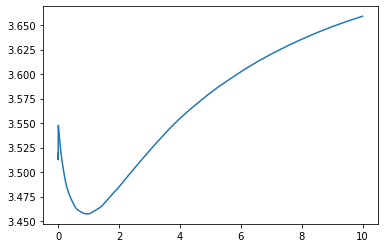

In [162]:
plt.plot(alphas, val_scores)

In [163]:
# best alpha
best_alpha = alphas[np.argmin(val_scores)]
print(best_alpha)

0.9440064789417604


In [164]:
model = Ridge(alpha=best_alpha)

In [165]:
np.concatenate((X_train, X_val))

array([[ 1.78675805,  1.78432466,  1.90207058, ...,  1.81856794,
         1.39834237,  1.73344458],
       [ 0.12864368,  0.13205119, -0.95620459, ...,  0.5193572 ,
         0.16883857,  0.68165027],
       [-0.85462905, -0.85649727,  0.94931219, ..., -1.12181262,
        -0.7453568 , -1.10928877],
       ...,
       [-0.5918384 , -0.59354658, -0.0034462 , ..., -0.50260374,
        -1.07927769, -0.5631775 ],
       [-0.28346196, -0.28549579, -0.0034462 , ..., -0.55850593,
        -0.84839306, -0.7835094 ],
       [-1.26646731, -1.26831254, -1.43258378, ..., -1.29106508,
        -0.6919108 , -1.07248829]])

In [166]:
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

Ridge(alpha=0.9440064789417604)

In [167]:
y_hat = model.predict(X_test)

In [168]:
mean_absolute_error(y_test, y_hat)

3.8124192984864242

In [169]:
np.sqrt(mean_squared_error(y_test, y_hat))

6.442169265534268

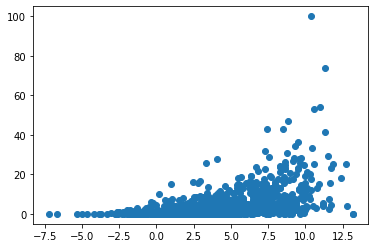

In [170]:
plt.scatter(y_hat, y_test)

In [184]:
model.coef_.flatten()

array([ -3.60048946,  -4.41525145, -21.02436361,  -0.1474853 ,
         0.20245731,  -0.1474853 ,  -1.46781574, -23.48402677,
        -9.60876005,   8.8402618 ,  -0.69372407,  -0.22517175,
        -0.91057866,  -1.89348549,   1.3894469 ,   1.3894469 ,
         0.46485352,  -0.07712354,   0.82441631,   0.82441631,
         0.        ,   0.        ,  -0.27697393,   0.05453281,
       -11.21652249,   8.30671197,  -1.7229228 , -13.32280916,
        50.36733077,  21.55306704,  -5.85307239,  -5.85307239,
        -2.06822638,  29.42612086, -21.90943228,   5.46706452,
         5.46706452,  -0.66859675, -15.33910203, -29.80320072,
        10.42909753,   2.16771584,  -0.94285028])

In [179]:
descriptor_names[-4]

'kappa1'

In [192]:
# get highest coefficients
highest_coefs = np.argsort(np.abs(model.coef_.flatten()))[::-1]

In [194]:
for idx in highest_coefs[:5]:
    print(descriptor_names[idx])
    print(model.coef_.flatten()[idx])

chi0v
50.36733077275107
kappa1
-29.803200717512386
chi0n
29.426120856892727
NumHeavyAtoms
-23.484026773879933
chi1n
-21.909432275459352


In [242]:
def iterable_to_nested_list(list_to_break_up, inner_len, pad_last=False, pad_value=None):
    "break up list into nested lists"
    # invert list for fast pop()
    list_tmp = list(reversed(list_to_break_up))

    outer_list = []
    while len(list_tmp) > 0:
        inner_list = []
        while len(inner_list) < inner_len:
            if len(list_tmp) == 0:
                if pad_last:
                    while len(inner_list) < inner_len:
                        inner_list.append(pad_value)
                break
            inner_list.append(list_tmp.pop())
        outer_list.append(inner_list)
    return outer_list

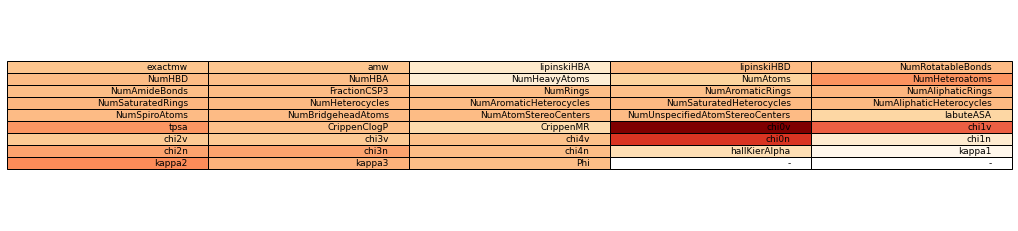

In [252]:
fig, ax = plt.subplots(figsize=(18,4))
ax.axis('tight')
ax.axis('off')

norm = plt.Normalize()
colors = iterable_to_nested_list(cm.OrRd(norm(model.coef_.flatten())), 5,True,  np.array([1.,1.,1.,1.]))

ax.table(cellText = iterable_to_nested_list(descriptor_names, 5, True, "-"), cellColours=colors, loc='center')
plt.show()

In [244]:
from matplotlib import cm